In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Załadowanie ocen z zbiory jester

In [2]:
# !pip install xlrd
ratings_data = pd.read_excel('jester_dataset_1_1/jester-data-1.xls', header=None)
ratings_data = ratings_data.iloc[:, 1:].replace(99, float('nan'))
ratings = ratings_data.mean()



Załadowanie żartów ze zbioru jester

In [3]:
jokes_data = []

for i in range(1, 101):
    file_name = f'jokes/init{i}.html'
    with open(file_name, 'r') as file:
        joke_html = file.read()
        soup = BeautifulSoup(joke_html, 'html.parser')
        joke_text = soup.find('font', size='+1').text.strip()
        jokes_data.append(joke_text)


In [6]:
# display first 5 jokes
print(jokes_data[:5])

['A man visits the doctor. The doctor says "I have bad news for you.You have\ncancer and Alzheimer\'s disease". \nThe man replies "Well,thank God I don\'t have cancer!"', 'This couple had an excellent relationship going until one day he came home\nfrom work to find his girlfriend packing. He asked her why she was leaving him\nand she told him that she had heard awful things about him. \n\n"What could they possibly have said to make you move out?" \n\n"They told me that you were a pedophile." \n\nHe replied, "That\'s an awfully big word for a ten year old."', "Q. What's 200 feet long and has 4 teeth? \n\nA. The front row at a Willie Nelson Concert.", "Q. What's the difference between a man and a toilet? \n\nA. A toilet doesn't follow you around after you use it.", "Q.\tWhat's O. J. Simpson's Internet address? \nA.\tSlash, slash, backslash, slash, slash, escape."]


In [4]:
model = SentenceTransformer('bert-base-cased')
embeddings = model.encode(jokes_data)

No sentence-transformers model found with name C:\Users\filip/.cache\torch\sentence_transformers\bert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\filip/.cache\torch\sentence_transformers\bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model 

transrormacja danych do postaci macierzy

In [8]:
# show embeddings for first 5 jokes 
print(embeddings[:5])

[[ 0.22689956  0.08085244  0.1937923  ...  0.3482189   0.16816409
   0.22305498]
 [ 0.08381999  0.15879391 -0.1869314  ...  0.24138355 -0.09729489
  -0.13394882]
 [ 0.02886736  0.04255906 -0.07353075 ...  0.24468488  0.04791435
  -0.17327295]
 [ 0.35024607 -0.16287668  0.02111016 ...  0.29077908  0.01691804
  -0.2879163 ]
 [ 0.21226716  0.17400326  0.33756033 ...  0.19055375  0.31695113
  -0.04640916]]


In [9]:
# use standardScaler to normalize embeddings
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# standarized_embeddings = scaler.fit_transform(embeddings)


In [10]:
# show normalized embeddings for first 5 jokes
print(standarized_embeddings[:5])


[[ 0.57696694  0.557637    1.4792502  ...  0.78502905  0.97633153
   2.0398936 ]
 [-0.45947197  1.1145145  -1.4929712  ... -0.11595911 -0.9187736
  -1.0661864 ]
 [-0.85753745  0.28403792 -0.6076787  ... -0.08811764  0.11787159
  -1.4083226 ]
 [ 1.4704635  -1.1837626   0.13116086 ...  0.3006146  -0.1034103
  -2.405767  ]
 [ 0.4709728   1.2231824   2.6016138  ... -0.54462856  2.0385184
  -0.3045554 ]]


podizelenie danych na zbiór treningowy i walidacyjny

In [6]:
train_X, val_X, train_y, val_y = train_test_split(
    embeddings, 
    ratings, 
    test_size=0.2, 
    random_state=3)

In [7]:
print("Train X shape:", train_X.shape)
print("Train y shape:", train_y.shape)
print("Validation X shape:", val_X.shape)
print("Validation y shape:", val_y.shape)

Train X shape: (80, 768)
Train y shape: (80,)
Validation X shape: (20, 768)
Validation y shape: (20,)


In [65]:
# stotne jest, by zacząć eksperymenty od możliwie jak najbardziej surowej sieci neuronowej. Jeśli
# korzystasz z Pythona i pakietu sklearn, konkretnie klasy sklearn.neural network.MLPRegressor,
# upewnij się, że przekazujesz następujące wartości hiperparametrów:
# • solver = ’sgd’
# • alpha = 0.0
# • learning rate = ’constant’

def run(learning_rate_param=0.001, hidden_sizes=(100,), loss_type='train') -> list:
    mlp = MLPRegressor(solver='sgd', 
                       alpha=0.0, 
                       learning_rate='constant',
                       learning_rate_init=learning_rate_param, 
                       hidden_layer_sizes=hidden_sizes,
                       random_state=0
                       )
    train_loss = []
    val_loss = []
    epochs = 1000

    for epoch in range(epochs):
        mlp.partial_fit(train_X, train_y)

        pred_train_y = mlp.predict(train_X)
        train_loss.append(mean_squared_error(train_y, pred_train_y))

        pred_val_y = mlp.predict(val_X)
        val_loss.append(mean_squared_error(val_y, pred_val_y))

    train_loss2 = mlp.loss_curve_

    if loss_type == 'train':
        return train_loss
    elif loss_type == 'val':
        return val_loss
    elif loss_type == 'loss':
        return train_loss2
    else:
        raise ValueError(f"Invalid loss_type: {loss_type}. Use 'train' or 'val'.")


2. Przetestuj działanie podstawowego modelu MLP o domyślnej konfiguracji hiperparametrów,
ucząc go na danych ze zbioru Jester. Prześledź zachowanie modelu w czasie, wizualizując
wartość funkcji kosztu w funkcji liczby epok, zwracając uwagę na wartości dla zbioru uczącego
i zbioru walidacyjnego. (20 punktów

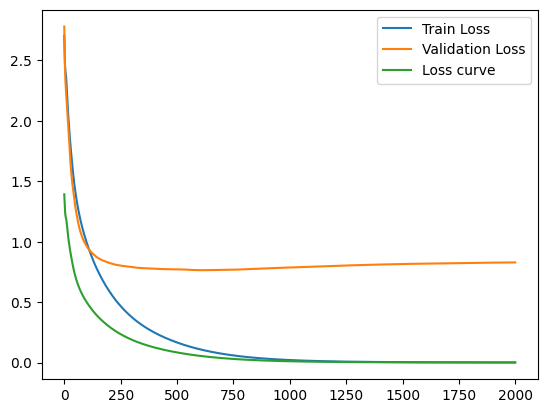

In [56]:
loss_train = run(loss_type='train')
loss_val = run(loss_type='val')
loss_curve = run(loss_type='loss')
plt.plot(range(len(loss_train)), loss_train, label=f'Train Loss')
plt.plot(range(len(loss_val)), loss_val, label=f'Validation Loss')
plt.plot(range(len(loss_curve)), loss_curve, label=f'Loss curve')
plt.legend()
plt.show()


In [17]:

# print each loss data 
print(f"Train loss: {loss_train}")
print(f"Validation loss: {loss_val}")
print(f"Loss curve: {loss_curve}")

Train loss: [2.7030565212442577, 2.613467670990352, 2.5342609338008875, 2.4752329146955963, 2.4371958699765033, 2.414487452448555, 2.3996714657141798, 2.385722051887325, 2.3661628845822, 2.338853442543655, 2.3057213725470134, 2.268834908917587, 2.230207124110902, 2.191636637542744, 2.154460722851698, 2.121095937630236, 2.0906741234030592, 2.0616996497573283, 2.0333904495840707, 2.0066009987970452, 1.9804885572205215, 1.9542574536581916, 1.9284493407102175, 1.9025680237080107, 1.8772613189455818, 1.8533603832511383, 1.8304364020846684, 1.8086078049305652, 1.7874818860192907, 1.766292771954264, 1.7452199109871285, 1.7243862646211554, 1.7038430084434721, 1.6837476486283252, 1.6639219937171545, 1.6441619291879708, 1.624744976563997, 1.605836032204548, 1.5869520399850465, 1.5685505597793046, 1.55059643657344, 1.5334653629438169, 1.5170250206433558, 1.5011001011467973, 1.4855918780236368, 1.4703905221706453, 1.4557084729181158, 1.4415280365270484, 1.4277290990829674, 1.4142727924362748, 1.40

3. Zbadaj wpływ tempa uczenia (learning rate) na osiągane wyniki: powtórz uczenie dla 3 różnych wartości parametru. Dobierz odpowiednią długość procesu uczenia (liczbę epok) jeśli to
konieczne. Przedstaw wyniki na wykresach jak w zadaniu poprzednim. Co dzieje się, gdy tempo
uczenia jest zbyt niskie? Co, gdy zbyt wysokie? (30 punktów)


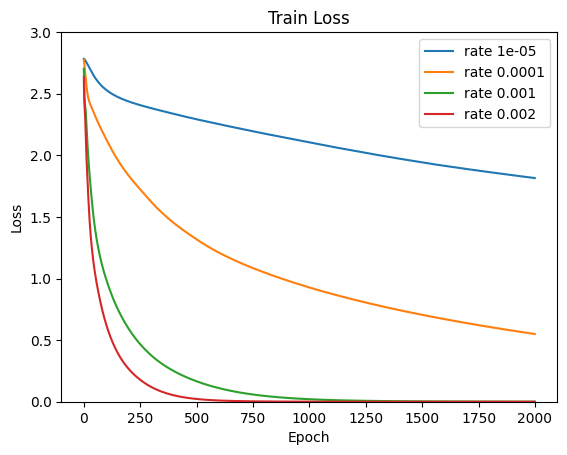

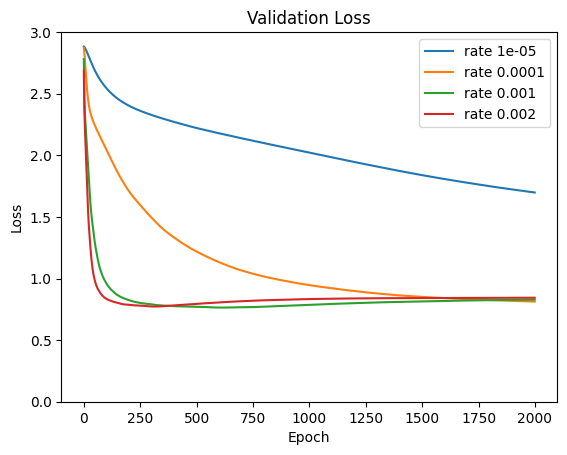

In [57]:
learning_rates = [0.00001, 0.0001, 0.001, 0.002]

for lr in learning_rates:
    train_loss =  run(learning_rate_param=lr, loss_type='train')
    plt.plot(range(len(train_loss)), train_loss, label=f'rate {lr}')
plt.title('Train Loss')
plt.ylim(0, 3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
    
for lr in learning_rates:
    val_loss =  run(learning_rate_param=lr, loss_type='val')
    plt.plot(range(len(val_loss)), val_loss, label=f'rate {lr}')
plt.title('Validation Loss')
plt.ylim(0, 3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

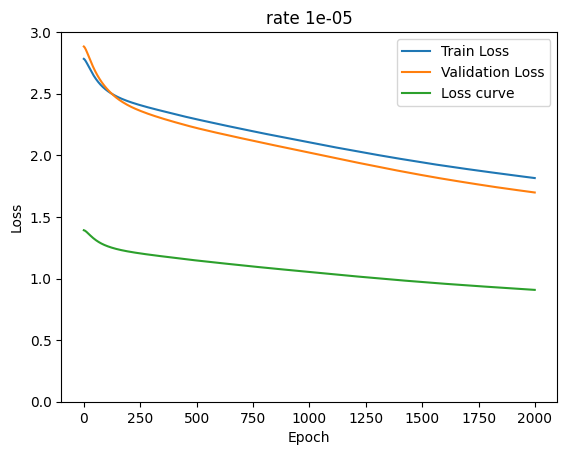

In [58]:
rate = 0.00001
loss_train = run(learning_rate_param=rate,loss_type='train')
loss_val = run(learning_rate_param=rate, loss_type='val')
loss_curve = run(learning_rate_param=rate, loss_type='loss')
plt.plot(range(len(loss_train)), loss_train, label=f'Train Loss')
plt.plot(range(len(loss_val)), loss_val, label=f'Validation Loss')
plt.plot(range(len(loss_curve)), loss_curve, label=f'Loss curve')
plt.ylim(0, 3)
plt.title(f'rate {rate}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

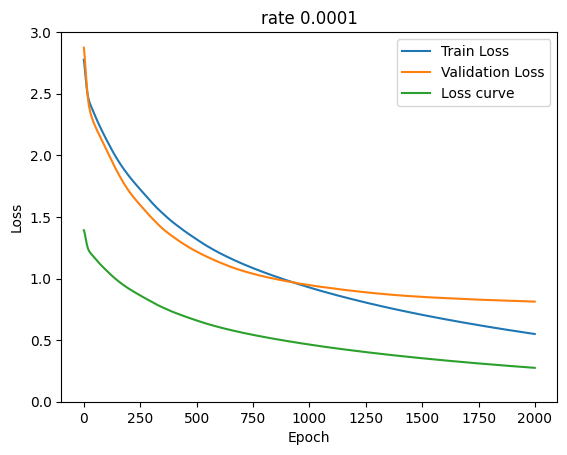

In [59]:
loss_train = run(learning_rate_param=0.0001,loss_type='train')
loss_val = run(learning_rate_param=0.0001, loss_type='val')
loss_curve = run(learning_rate_param=0.0001, loss_type='loss')
plt.plot(range(len(loss_train)), loss_train, label=f'Train Loss')
plt.plot(range(len(loss_val)), loss_val, label=f'Validation Loss')
plt.plot(range(len(loss_curve)), loss_curve, label=f'Loss curve')
plt.ylim(0, 3)
plt.title('rate 0.0001')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

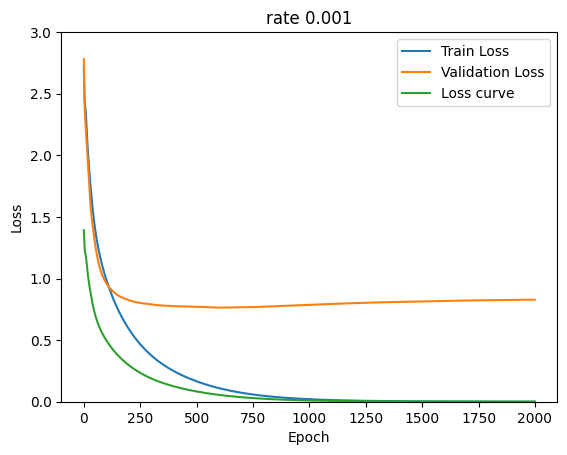

In [60]:
rate = 0.001
loss_train = run(learning_rate_param=rate,loss_type='train')
loss_val = run(learning_rate_param=rate, loss_type='val')
loss_curve = run(learning_rate_param=rate, loss_type='loss')
plt.plot(range(len(loss_train)), loss_train, label=f'Train Loss')
plt.plot(range(len(loss_val)), loss_val, label=f'Validation Loss')
plt.plot(range(len(loss_curve)), loss_curve, label=f'Loss curve')
plt.ylim(0, 3)
plt.title(f'rate {rate}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

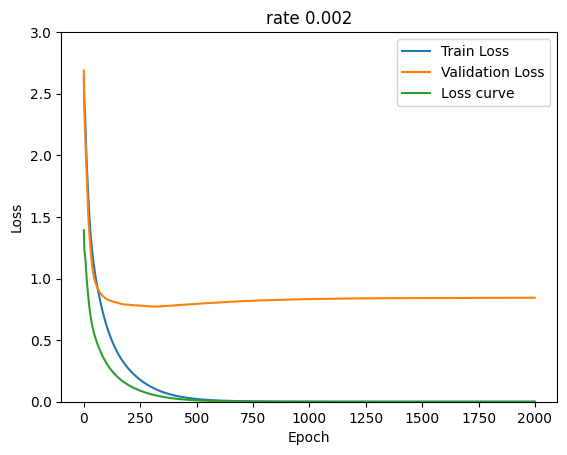

In [61]:
rate = 0.002
loss_train = run(learning_rate_param=rate,loss_type='train')
loss_val = run(learning_rate_param=rate, loss_type='val')
loss_curve = run(learning_rate_param=rate, loss_type='loss')
plt.plot(range(len(loss_train)), loss_train, label=f'Train Loss')
plt.plot(range(len(loss_val)), loss_val, label=f'Validation Loss')
plt.plot(range(len(loss_curve)), loss_curve, label=f'Loss curve')
plt.ylim(0, 3)
plt.title(f'rate {rate}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

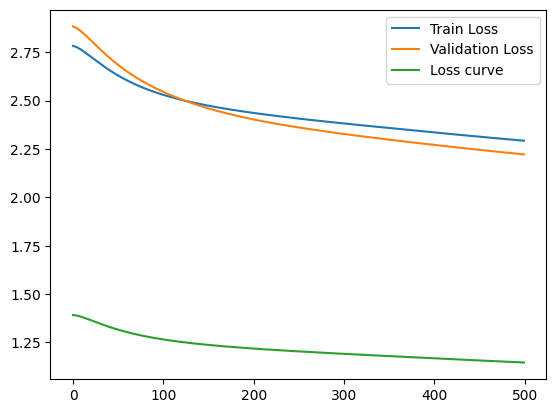

In [15]:
loss_train = run(learning_rate_param=0.00001,loss_type='train')
loss_val = run(learning_rate_param=0.00001, loss_type='val')
loss_curve = run(learning_rate_param=0.00001, loss_type='loss')
plt.plot(range(len(loss_train)), loss_train, label=f'Train Loss')
plt.plot(range(len(loss_val)), loss_val, label=f'Validation Loss')
plt.plot(range(len(loss_curve)), loss_curve, label=f'Loss curve')
plt.legend()
plt.show()

4. Zbadaj wpływ rozmiaru modelu MLP na jakość działania: wykonaj co najmniej 3 eksperymenty
dla modeli różniących się liczbą neuronów. Kiedy model przestaje dobrze dopasowywać się do
danych? Kiedy zaczyna zanadto dopasowywać się do zbioru uczącego? (30 punktów)

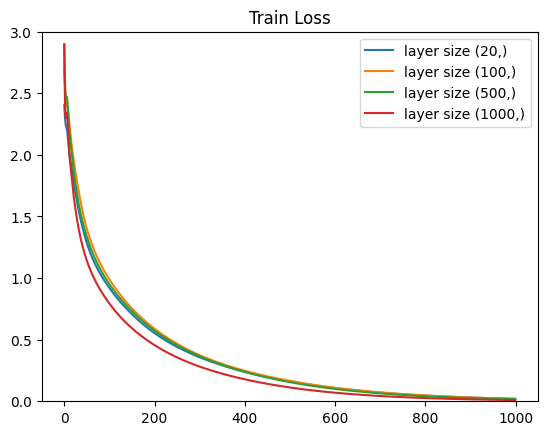

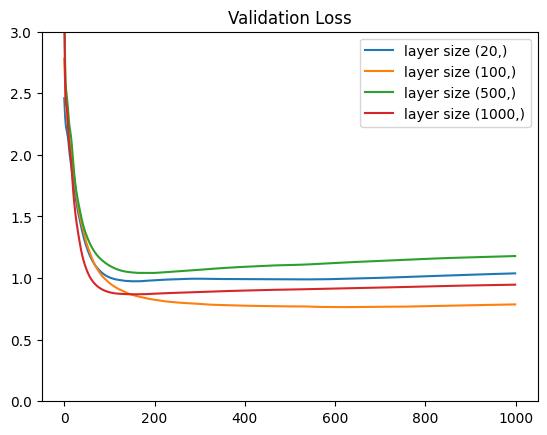

In [66]:
hidden_layer_sizes = [(20,), (100,), (500,), (1000,)]

for size in hidden_layer_sizes:
    loss_train = run(learning_rate_param=0.001, hidden_sizes=size, loss_type='train')
    plt.plot(range(len(loss_train)), loss_train, label=f'layer size {size}')
plt.title('Train Loss')
plt.ylim(0, 3) 
plt.legend()
plt.show()

for size in hidden_layer_sizes:
    loss_val = run(learning_rate_param=0.001, hidden_sizes=size, loss_type='val')
    plt.plot(range(len(loss_val)), loss_val, label=f'layer size {size}')
plt.title('Validation Loss')
plt.ylim(0, 3)
plt.legend()
plt.show()

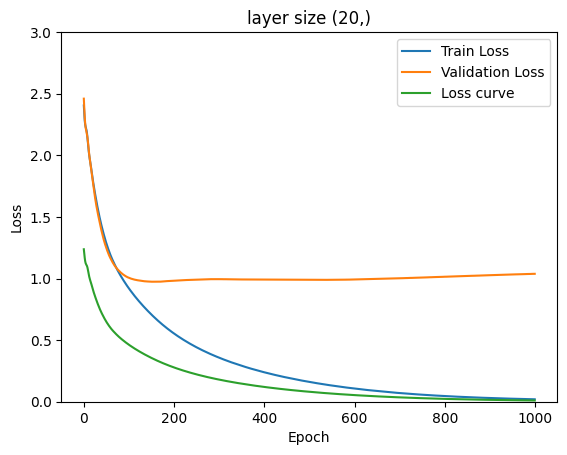

In [67]:
loss_train = run(loss_type='train', hidden_sizes=(20,))
loss_val = run(loss_type='val',hidden_sizes=(20,))
loss_curve = run(loss_type='loss', hidden_sizes=(20,))
plt.plot(range(len(loss_train)), loss_train, label=f'Train Loss')
plt.plot(range(len(loss_val)), loss_val, label=f'Validation Loss')
plt.plot(range(len(loss_curve)), loss_curve, label=f'Loss curve')
plt.title('layer size (20,)')
plt.ylim(0, 3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

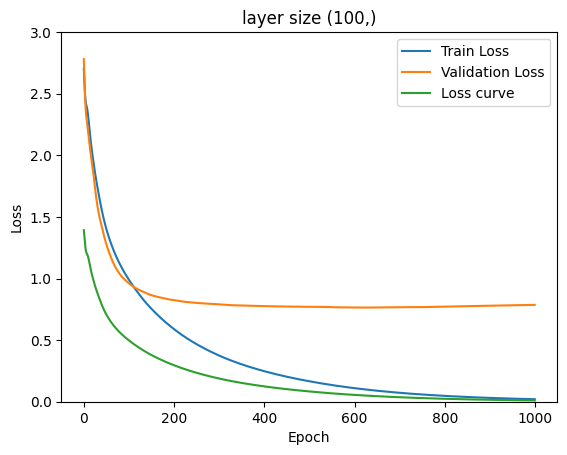

In [68]:
size = (100,)
loss_train = run(loss_type='train', hidden_sizes=size)
loss_val = run(loss_type='val',hidden_sizes=size)
loss_curve = run(loss_type='loss', hidden_sizes=size)
plt.plot(range(len(loss_train)), loss_train, label=f'Train Loss')
plt.plot(range(len(loss_val)), loss_val, label=f'Validation Loss')
plt.plot(range(len(loss_curve)), loss_curve, label=f'Loss curve')
plt.title(f'layer size {size}')
plt.ylim(0, 3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

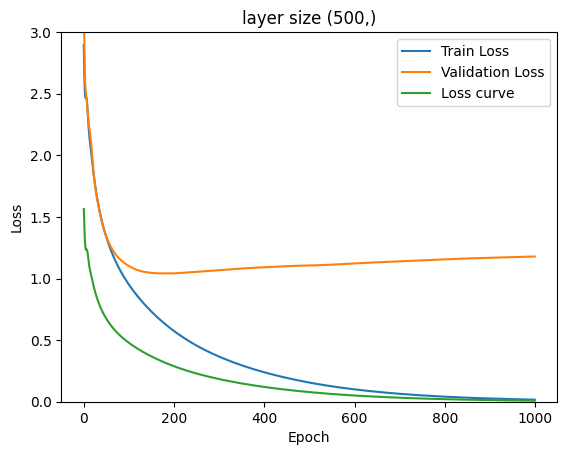

In [69]:
size = (500,)
loss_train = run(loss_type='train', hidden_sizes=size)
loss_val = run(loss_type='val',hidden_sizes=size)
loss_curve = run(loss_type='loss', hidden_sizes=size)
plt.plot(range(len(loss_train)), loss_train, label=f'Train Loss')
plt.plot(range(len(loss_val)), loss_val, label=f'Validation Loss')
plt.plot(range(len(loss_curve)), loss_curve, label=f'Loss curve')
plt.title(f'layer size {size}')
plt.ylim(0, 3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

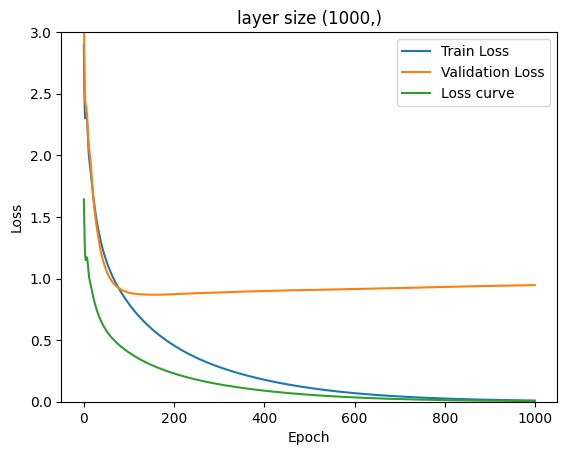

In [71]:
size = (1000,)
loss_train = run(loss_type='train', hidden_sizes=size)
loss_val = run(loss_type='val',hidden_sizes=size)
loss_curve = run(loss_type='loss', hidden_sizes=size)
plt.plot(range(len(loss_train)), loss_train, label=f'Train Loss')
plt.plot(range(len(loss_val)), loss_val, label=f'Validation Loss')
plt.plot(range(len(loss_curve)), loss_curve, label=f'Loss curve')
plt.title(f'layer size {size}')
plt.ylim(0, 3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

5. Wybierz najlepszy uzyskany w drodze powyższych eksperymentów model i przetestuj go w
praktyce: znajdź (lub napisz własny) tekst o charakterze dowcipu, przetwórz go na wektor za
pomocą używanej w zadaniach metody ekstrakcji cech, a następnie odpytaj model neuronowy.
Czy predykcja zgadza się z Twoim oczekiwaniem? (15 punktów)

In [89]:
my_mlp = MLPRegressor(solver='sgd', alpha=0.0, learning_rate='constant',
                      learning_rate_init=0.001, hidden_layer_sizes=(100,), max_iter=200, random_state=0)

my_mlp.fit(train_X, train_y)


C:\Users\filip\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=0.0, random_state=0, solver='sgd')

In [90]:
def my_joke(joke):
    joke_embedding = model.encode([joke])
    joke_embedding = np.reshape(joke_embedding, (1, -1))
    rating_prediction = my_mlp.predict(joke_embedding)
    print("Predykcja oceny żartu:", rating_prediction)


In [97]:

joke = "What kind of dog does a magician have? A Labracadabrador!"
my_joke(joke)





Predykcja oceny żartu: [-1.7899495]


In [114]:
joke = 'A multilayer perceptron (MLP) is a fully connected class of feedforward artificial neural network (ANN). The term MLP is used ambiguously, sometimes loosely to mean any feedforward ANN, sometimes strictly to refer to networks composed of multiple layers of perceptrons'
my_joke(joke)

Predykcja oceny żartu: [0.82006764]


In [116]:
joke = '''A pair of cows were talking in the field. One says, “Have you heard about the mad cow disease that’s going around?”

“Yeah,” the other cow says. “Makes me glad I’m a penguin.”'''

my_joke(joke)   

Predykcja oceny żartu: [-0.10538837]


In [117]:
joke = 'When I was a kid, my dad got fired from his job as a road worker for theft. I refused to believe he could do such a thing, but when I got home, the signs were all there.'
my_joke(joke)

Predykcja oceny żartu: [-0.01313317]


In [118]:
joke = 'Lost my job at the bank on my first day. A woman asked me to check her balance, so I pushed her over.'
my_joke(joke)

Predykcja oceny żartu: [0.06110469]


In [119]:
joke = 'my dad is a priest and my mom is a nun, how did they meet? they met during church'
my_joke(joke)

Predykcja oceny żartu: [0.30441502]


In [120]:
joke = 'Just paid £200 for a belt that doesn’t fit! What a huge waist!'
my_joke(joke)

Predykcja oceny żartu: [-0.36792654]
